                                                                                               Anuj Maharjan

# Understanding Latent Representations of Autoencoders

### Loss Landscape
    Loss landscape is a representation of loss values around the weight space. 
    We use two Random Directions(RD) vectors that are same size as weights of the autoencoder. 
    These RD compose a 2D plane in high dimensional space taking minimizer as reference point.
On that 2D plane, we create a 9x9 grid and compute loss values for each grid points $(\alpha,\beta)$ to form a loss landscape.

$$f({\alpha},{\beta})=L(\theta^* + \alpha\delta + \beta\eta) \text{, where }\delta  \text{ and } \eta  \text{ are random directions } $$
    
   <img src="../random_directions.png" height="200" width="200"/>
      
    
In this experiment, we build a simple conv autoencoder having latent representation of size 8.
We use each components of latent representation instead of loss values for visualization.

In [1]:
import sys
import os
import glob
from time import time

In [2]:
#install all necessary libraries
#!{sys.executable} -m pip install torchsummary selenium plotly bokeh

In [3]:
import torch 
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable
from torchsummary import summary

import numpy as np
import pandas as pd

In [4]:
#visualization

import matplotlib.pyplot as plt
from matplotlib import ticker,colors
%matplotlib inline
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox

import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots
import plotly.express as px

from bokeh.plotting import figure, show, output_file
from bokeh.layouts import row
from bokeh.sampledata.iris import flowers
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
from bokeh.palettes import viridis
from bokeh.palettes import brewer
from bokeh.palettes import d3
from bokeh.io import export_png
from bokeh.models import Arrow, NormalHead, OpenHead, VeeHead


output_notebook() # display plot in jupyter notebook when bokeh show() is called

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import pickle

Loading BokehJS ...

In [5]:
#k-means clustering

from numpy import unique
from numpy import where
from sklearn.cluster import KMeans

In [6]:
seed=0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed) 

num_epochs = 100
batch_size = 100
latent_size = 2 # change to get latent representation of different size
startEpoch = 0
loadSavedModel = True 
# uncomment it when using latent_size of 2 dimension
saveModelDir="weights-2D/"
# comment it when using latent_size of 2 dimension
# saveModelDir="weights/"
weights="100_epoch.pth" # 100_epoch.pth


In [7]:
# MNIST dataset
dataset = dsets.MNIST(root='../data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                            batch_size=batch_size,
                                            shuffle=True)

In [8]:
def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

In [9]:
class Autoencoder(nn.Module):
    def __init__(self,latentSpaceSize=8,in_dim=784):
        super(Autoencoder, self).__init__()
        self.latentSpaceSize=latentSpaceSize
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7),
            nn.ReLU()
        )
        self.encoderLin=nn.Sequential(
            nn.Linear(64,latentSpaceSize),
            nn.ReLU()
        )
   
        self.decoderLin=nn.Sequential(
            nn.Linear(latentSpaceSize,64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        elatent = self.encoder(x)
        flattened=elatent.view(elatent.size(0), -1)
        encoded=self.encoderLin(flattened)
        
        dLatent=self.decoderLin(encoded)
        convDim=dLatent.reshape(dLatent.size(0),64,1,1)
        decoded = self.decoder(convDim)
        
        return encoded,decoded
    

In [10]:
ae = Autoencoder(latent_size)

if torch.cuda.is_available():
    ae.cuda()

criterion = nn.MSELoss() 
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)


In [11]:
if loadSavedModel:
    model=saveModelDir+weights
    if os.path.exists(model):
        ae.load_state_dict(torch.load(model, map_location=lambda storage, loc: storage))
        print('Pre-trained model is loaded:', weights)

    startEpoch=int(weights.split("_")[0])
    
            
    #if loading the last model, evaluate the model to accummulate latent representation
    print("evaluating model..")

    encodedDict={}
    labelDict={}
    encodedList=[]
    labelList=[]
    with torch.no_grad(): # run the model at least once to load the latent representations for visualization
        for i, (images, labels) in enumerate(data_loader):
            img = to_var(images)
            encoded,decoded = ae(img)
            loss = criterion(decoded, img)
            encodedList.extend(encoded)
            labelList.extend(labels.numpy())
        encodedDict[startEpoch-1]=encodedList
        labelDict[startEpoch-1]=labelList
    print("compute latent representation completed")

Pre-trained model is loaded: 100_epoch.pth
evaluating model..
compute latent representation completed


We train the autoencoder until the loss converges.
We can save latent representation of each epoch and visualize how its latent landscape changes over each iteration.
Following code only saves the latent representation of last epoch.

For saving latent repr of all the epochs use
```python
encodedDict={}
labelDict={}
for epoch in range(num_epochs):
    encodedList=[]
    labelList=[]
    for i, (images, labels) in enumerate(data_loader):

```

In [12]:
def checkpoint(epoch):
    if not os.path.exists(saveModelDir):
        os.mkdir(saveModelDir)
        print("Directory " , saveModelDir ,  " Created ")
        
    model_out_path = saveModelDir+"{}_epoch.pth".format(epoch+1)
    torch.save(ae.state_dict(), model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))
    
for epoch in range(startEpoch,num_epochs):
    encodedDict={}
    labelDict={}
    encodedList=[]
    labelList=[]
    training_loss = 0
    for i, (images, labels) in enumerate(data_loader):
        img = to_var(images)
        encoded,decoded = ae(img)
        loss = criterion(decoded, img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        if (i+1) % 100 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f' 
                %(epoch+1, num_epochs, i+1, len(dataset)//batch_size, loss.data))
        encodedList.extend(encoded)
        labelList.extend(labels.numpy())
    if (epoch+1) % 10 == 0:
        checkpoint(epoch)
    # compute the epoch training loss
    training_loss = training_loss / len(data_loader)
    # display the epoch average training loss
    print("Epoch average training loss: {}/{}, loss = {:.6f}".format(epoch + 1, num_epochs, training_loss))
    encodedDict[epoch]=encodedList
    labelDict[epoch]=labelList

Here we trained our model and saved the latent space representation for plotting.
We have 60000 training images and we have a latent space of size 8 per image. Hence we have a array of 60000*8 per epoch.


## PCA
    PCA gives us direction of maximum variance and helps to project data into lower dimensions. We compute PCA and visualize the projected representation with a scatter plot.

In [13]:
colormap={0:"black",1:"silver",2:"red",3:"blue",4:"green",5:"yellow",6:"darkcyan",7:"yellowgreen",8:"royalblue",9:"purple"}
#colormap={i:v for i,v in enumerate(d3['Category10'][10])}
colorLegend={0:"0",1:"1",2:"2",3:"3",4:"4",5:"5",6:"6",7:"7",8:"8",9:"9"}
df = pd.DataFrame(encodedDict[num_epochs-1])
pca = PCA()
pca.fit(df) 


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\decomposition\pca.py:447: RuntimeWarning:

invalid value encountered in true_divide



PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [14]:
def compute_pca(plot_epoch):
    df = pd.DataFrame(encodedDict[plot_epoch])
    pcaNewCoord = pca.transform(df)
    pcaNewCoord = pd.DataFrame(pcaNewCoord)
    return pcaNewCoord

def plot_latent_space(newPCA1,newPCA2,plot_epoch):
    colors = [colormap[x] for x in labelDict[plot_epoch]]
    colorLegends=[colorLegend[x] for x in labelDict[plot_epoch]]

    p = figure(title = "MNIST")
    p.plot_width=800
    p.xaxis.axis_label = 'PCA1'
    p.yaxis.axis_label = 'PCA2'

    source = ColumnDataSource({'x':newPCA1,'y':newPCA2,'colors':colors,'labels':colorLegends})
    p.circle(x='x',y='y',color='colors', size=5,legend='labels',source=source)

    p.legend.location = "top_left"
    #output_file("PCA.html", title="MNIST")
    
    show(p)
    

In [15]:
def plot2DLatentSpace(plot_epoch):
    
    df_latentSpace = pd.DataFrame(torch.stack(encodedDict[plot_epoch]).numpy())
    p = figure(title = "MNIST")
    p.plot_width=800
    p.xaxis.axis_label = 'Feature 1'
    p.yaxis.axis_label = 'Feature 2'
    colors = [colormap[x] for x in labelDict[plot_epoch]]
    colorLegends=[colorLegend[x] for x in labelDict[plot_epoch]]
    
    source = ColumnDataSource({'x':df_latentSpace[0],'y':df_latentSpace[1],'colors':colors,'labels':colorLegends})
    p.circle(x='x',y='y',color='colors', size=5,legend='labels',source=source)

    p.legend.location = "top_left"
    show(p)

In [16]:
if latent_size > 2:
    newPCA=compute_pca(num_epochs-1)
    plot_latent_space(newPCA[0],newPCA[1],num_epochs-1)
else:
    plot2DLatentSpace(num_epochs-1)

#plot for all epochs
#for i in range(num_epochs):
#    plot_latent_space(i)


In [17]:
#plot_latent_space(newPCA[0],newPCA[2],num_epochs-1)

## TSNE
    PCA maintains the global structure of datapoints.
    TSNE is a method for visualization where it maintains its local structure i.e distance between its 2 neighbors.


In [18]:
def compute_tsne(df):  
    model = TSNE(n_components=2, random_state=0)
    tsne_data = model.fit_transform(df)
    tsne = pd.DataFrame(tsne_data)
    return tsne

In [19]:
df = pd.DataFrame(encodedDict[num_epochs-1])
tsne=compute_tsne(df)

In [20]:
plot_latent_space(tsne[0],tsne[1],num_epochs-1)

## K-Means Clustering

In [21]:
def KmeansFunction():
    # define the model
    model = KMeans(n_clusters=10, init='random', n_init=20, max_iter=300, tol=1e-04, random_state=0)
    df_latent = pd.DataFrame(encodedDict[num_epochs-1])
    # assign a cluster to each example
    y_kmeans = model.fit_predict(df_latent)
    centroids = model.cluster_centers_
    labelSet = model.labels_
    return (df_latent, centroids, labelSet)

In [22]:
# k-means clustering and then display using PCA

def KmeansToPCA(df_latent, centroids, labelSet):

    #compute the PCA for plotting

    pcaNewCoord_latent = pca.transform(df_latent) 
    pcaNewCoord_latent = pd.DataFrame(pcaNewCoord_latent)
 
    #compute the PCA of the centroids for plotting

    df_centroids = pd.DataFrame(centroids)
    pcaNewCoord_centroids = pca.transform(df_centroids) 
    pcaNewCoord_centroids = pd.DataFrame(pcaNewCoord_centroids)
    
    colors = [colormap[x] for x in labelSet]
    
    p = figure(title = "MNIST with K Means Clustering")
    p.plot_width=800
    p.xaxis.axis_label = 'PCA1'
    p.yaxis.axis_label = 'PCA2'
    source = ColumnDataSource({'x':pcaNewCoord_latent[0],'y':pcaNewCoord_latent[1],'colors':colors,'labels':labelSet})
    p.circle(x='x',y='y',color='colors', size=5 ,source=source)

    arrowDirection = 5
    for i in range(10):
        d = plot_linear_interpolations(i, centroids)
        arrowDirection = -5 if arrowDirection == 5 else 5
        coordXStart = pcaNewCoord_centroids[0][i] + arrowDirection
        coordYStart = pcaNewCoord_centroids[1][i] + 5
        coordXEnd = pcaNewCoord_centroids[0][i]
        coordYEnd = pcaNewCoord_centroids[1][i]
        img = np.flipud(d)
        p.add_layout(Arrow(end=OpenHead(size=20, line_color="white",line_width=2),line_color="white",line_width=2,
                   x_start=coordXStart, y_start=coordYStart, 
                           x_end=coordXEnd, y_end=coordYEnd))
        p.image(image=[img], x=coordXStart, y=coordYStart, dw=2, dh=2, level="overlay")

    show(p)
    


In [23]:
# k-means clustering and then display using TSNE

def KmeansToTSNE(df_latent, centroids, labelSet):
    
    #append the centroids to latent data set
    
    df_centroids = pd.DataFrame(centroids)
    df_latent = df_latent.append(df_centroids)
    
    #compute the TSNE for plotting
    tsne_latent=compute_tsne(df_latent)
    tsne_coord = tsne_latent[0:60000]
    tsne_centroids = tsne_latent[60000:60010]
    tsne_centroids = tsne_centroids.to_numpy()

    colors = [colormap[x] for x in labelSet]

    p = figure(title = "MNIST with K Means Clustering and display using TSNE")
    p.plot_width=800
    p.xaxis.axis_label = 'PCA1'
    p.yaxis.axis_label = 'PCA2'
    source = ColumnDataSource({'x':tsne_coord[0],'y':tsne_coord[1],'colors':colors,'labels':labelSet})
    p.circle(x='x',y='y',color='colors', size=5 ,source=source)
    arrowDirection = 5
    for i in range(10):
        d = plot_linear_interpolations(i, centroids)
        arrowDirection = -5 if arrowDirection == 5 else 5
        coordXStart = tsne_centroids[i][0] + arrowDirection
        coordYStart = tsne_centroids[i][1] + 5
        coordXEnd = tsne_centroids[i][0]
        coordYEnd = tsne_centroids[i][1]
        img = np.flipud(d)
        p.add_layout(Arrow(end=OpenHead(size=20, line_color="white",line_width=2),line_color="white",line_width=2,
                   x_start=coordXStart, y_start=coordYStart, 
                           x_end=coordXEnd, y_end=coordYEnd))
        p.image(image=[img], x=coordXStart, y=coordYStart, dw=5, dh=5, level="overlay")

    show(p)
    
    


In [30]:
# k-means clustering of 2D latent space

def KmeansLatentspace2D():

    # define the model
    model = KMeans(n_clusters=10, init='random', n_init=20, max_iter=300, tol=1e-04, random_state=0)
    df_latent = pd.DataFrame(torch.stack(encodedDict[num_epochs-1]).numpy())
    # assign a cluster to each example
    y_kmeans = model.fit_predict(df_latent)
    centroids = model.cluster_centers_
    labelSet = model.labels_
    
    colors = [colormap[x] for x in labelSet]
    
    p = figure(title = "MNIST with K Means Clustering")
    p.plot_width=800
    p.xaxis.axis_label = 'Feature 1'
    p.yaxis.axis_label = 'Feature 2'
    source = ColumnDataSource({'x':df_latent[0],'y':df_latent[1],'colors':colors,'labels':labelSet})
    p.circle(x='x',y='y',color='colors', size=5 ,source=source)
    arrowDirection = 5
    for i in range(10):
        d = plot_linear_interpolations(i, centroids)
        arrowDirection = -5 if arrowDirection == 5 else 5
        coordXStart = centroids[i][0] + arrowDirection
        coordYStart = centroids[i][1] + 5
        coordXEnd = centroids[i][0]
        coordYEnd = centroids[i][1]
        img = np.flipud(d)
        p.add_layout(Arrow(end=OpenHead(size=20, line_color="white",line_width=2),line_color="white",line_width=2,
                   x_start=coordXStart, y_start=coordYStart, 
                           x_end=coordXEnd, y_end=coordYEnd))
        p.image(image=[img], x=coordXStart, y=coordYStart, dw=0.05, dh=0.05, level="overlay")
    show(p)


In [31]:
def plot_linear_interpolations(index, centroids):
    x = torch.tensor(centroids[index])
    decLatent = ae.decoderLin(x.reshape(1,-1).float())
    convDimDec= decLatent.reshape(decLatent.size(0),64,1,1)
    img = ae.decoder(convDimDec)
    img = img.detach().numpy()
    return img.reshape(28,28)

In [32]:
def plot_kmeans():
    
    (df_latent, centroids, labelSet) = KmeansFunction()
    if latent_size > 2:
        KmeansToPCA(df_latent, centroids, labelSet)
        KmeansToTSNE(df_latent, centroids, labelSet)
        
    else:
        KmeansLatentspace2D()
#         KmeansToTSNE(df_latent, centroids, labelSet)

    
plot_kmeans()

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning:

Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning:

Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.



## Filter Normalization

The random direction is vector of same shape as weights of the network. The weights of random directions is a normal distribution. 
We normalize the weights of random directions such that the filter of each layers have same norm as the corresponding filters of autoencoder.
Also, we can normalize such that each layer of random direction has same norm as the layers of autoencoder.

In [34]:
#to visualize the historgram of weights (difference when filter normalization is applied)
def viz_histogram_weights(converged_weights, direction1,direction2,title="None"):
    plt.figure(figsize=(55,55//9))
    plt.suptitle(title, fontsize=20, y=1.15)
    for layer_index in range(len(converged_weights)):
        plt.subplot(2,8,layer_index+1)
        plt.title("Layer : " + str(layer_index))
        plt.hist(converged_weights[layer_index].cpu().numpy().ravel(),50,alpha=0.6,label='Weight')
        plt.hist(direction1[layer_index].cpu().numpy().ravel(),50,alpha=0.2,label='Direction 1')
        plt.hist(direction2[layer_index].cpu().numpy().ravel(),50,alpha=0.2,label='Direction 2')
        plt.yticks([])
        plt.legend()
        #plt.savefig(title+'.png')

    plt.show()

In [35]:
def get_weights(ae):
    return [p.data for p in ae.parameters()]

#normalizing weights of each layer of random direction with network weights w
def get_random_weights(copy_of_the_weights):
    direction=[]
    for w in copy_of_the_weights:
        random_vector = torch.randn(w.shape) 
        random_vector = random_vector * (w.norm()/(random_vector.norm()+1e-10))
        direction.append(random_vector)
    return direction
    

In [36]:
#normalizing weights of each filter of each layer of random direction with network weights w
def get_random_weights_filter_norm(copy_of_the_weights):
    direction=[]
    for layer_weights in copy_of_the_weights:
        randDir = torch.randn(layer_weights.shape) 
        for d, w in zip(randDir, layer_weights): 
            d.mul_(w.norm()/(d.norm() + 1e-10))
        direction.append(randDir)  
    
    return direction

In [37]:
weights=get_weights(ae)
copy_of_the_weights = [ w.clone() for w in weights]

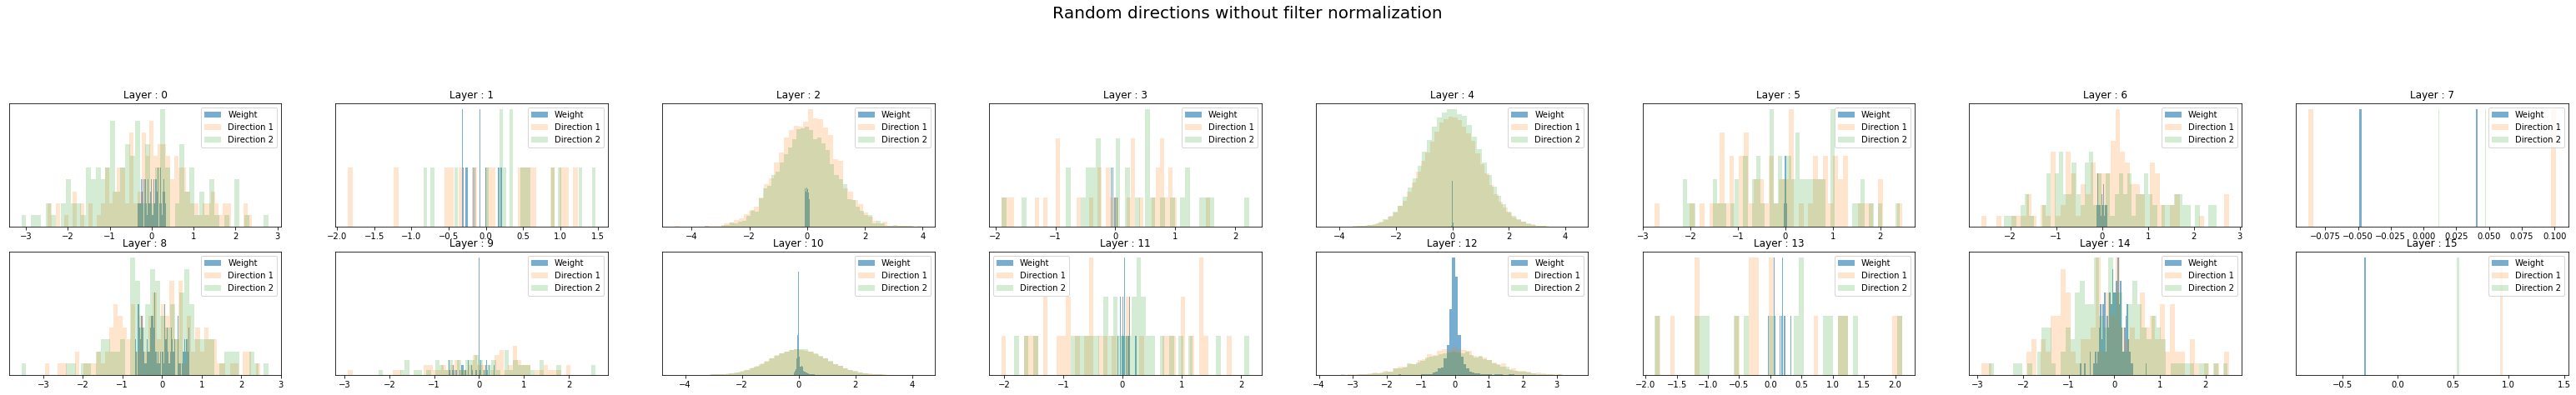

In [38]:
#display without normalization
dir1=[torch.randn(w.size()) for w in copy_of_the_weights]
dir2=[torch.randn(w.size()) for w in copy_of_the_weights]

viz_histogram_weights(copy_of_the_weights,dir1,dir2,"Random directions without filter normalization")

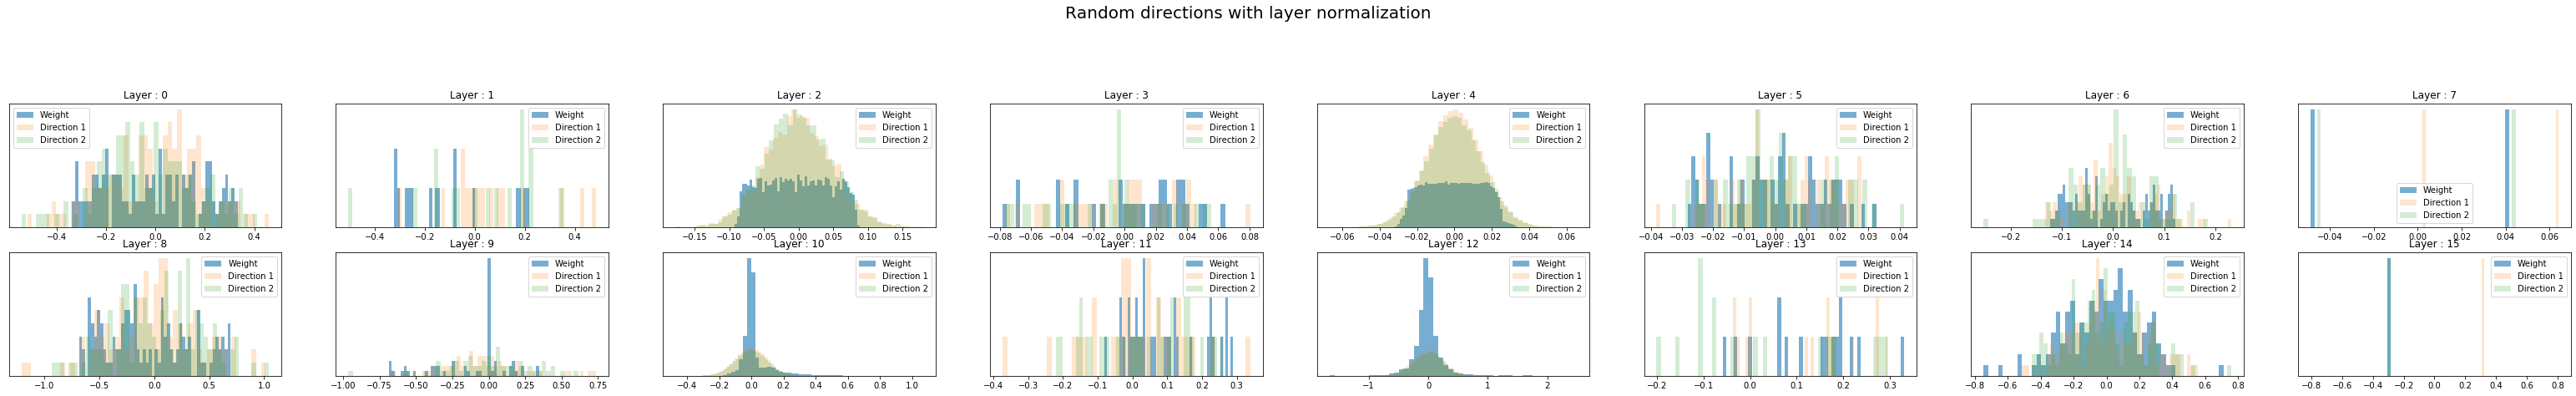

In [39]:
direction1=get_random_weights(copy_of_the_weights)
direction2=get_random_weights(copy_of_the_weights)

viz_histogram_weights(copy_of_the_weights,direction1,direction2,"Random directions with layer normalization")

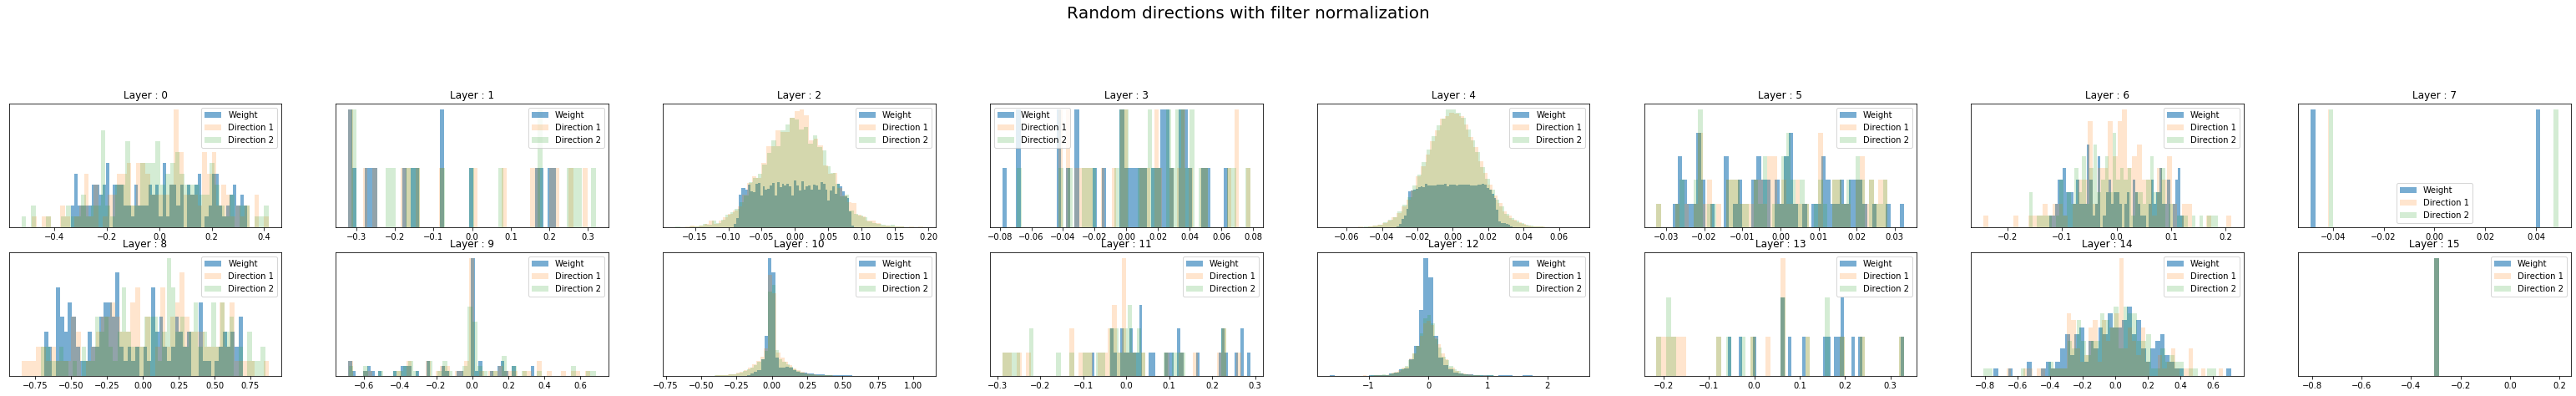

In [40]:
direction1=get_random_weights_filter_norm(copy_of_the_weights)
direction2=get_random_weights_filter_norm(copy_of_the_weights)

viz_histogram_weights(copy_of_the_weights,direction1,direction2,"Random directions with filter normalization")

In [41]:
# create the coordinates 
number_of_points = 9 
small_range = -1.0
large_range =  1.0

xcoordinates = np.linspace(small_range, large_range, num=number_of_points) 
ycoordinates = np.linspace(small_range, large_range, num=number_of_points) 

xcoord_mesh, ycoord_mesh = np.meshgrid(xcoordinates, ycoordinates)
total_cordinates = np.array(range(number_of_points**2))
alpha   = xcoord_mesh.ravel()[total_cordinates]
beta   = ycoord_mesh.ravel()[total_cordinates]
coordinate = np.c_[alpha,beta]
print('From ',small_range,' to ',large_range,' with ',number_of_points,' total number of coordinate: ', number_of_points**2)

From  -1.0  to  1.0  with  9  total number of coordinate:  81


In [42]:
def create_viz(loss_list,title="none"):
    
    fig = go.Figure(data =
        go.Contour(z=loss_list,x=xcoordinates,y=ycoordinates))
    
    fig.update_layout(height=400, width=500, title_text="Subplots")
    fig.show()
    
    data = [
        go.Surface(
            x=xcoord_mesh,y=ycoord_mesh,z=loss_list,colorscale='Jet',opacity=0.9,
            contours=go.surface.Contours(z=go.surface.contours.Z(show=True,usecolormap=True,project=dict(z=True),),
            )
        )
    ]
    layout = go.Layout(title='Loss',autosize=True,scene=dict(camera=dict(eye=dict(x=1.87, y=0.88, z=-0.64))),margin=dict(l=65,r=50,b=65,t=90))
    fig    = go.Figure(data=data,layout=layout); 
    
    fig.update_layout(height=400, width=600, title_text="Subplots")
    iplot(fig); 
    plt.show()
    
 

In [43]:
dataset_eval = dsets.MNIST(root='../data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)



In [44]:
targetByDigits=[]
dataByDigits=[]

for i in range(10):
    dataset_eval = dsets.MNIST(root='../data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)
    
    labelIndex= dataset_eval.train_labels==i #get the index of digit i
    targetByDigits.append(dataset_eval.train_labels[labelIndex]) 
    dataByDigits.append(dataset_eval.train_data[labelIndex]) 

C:\Users\Administrator\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:45: UserWarning:

train_labels has been renamed targets

C:\Users\Administrator\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:55: UserWarning:

train_data has been renamed data



## Loss landscape from latent representation of autoencoder

For each digit in mnist dataset, there around 6-7 thousand dataset. We get same number of latent representation. To create a loss landscape, we can compute the mean value of all components in latent representation.
    
In our experiment, we took the mean of latent representation column wise for all datapoints of each digits. As an output we get 8 components in latent representation. We use each component to create a loss landscape.
The same process is done for all 9x9=81 grid points. Hence we get 8 loss landscape.

<img src="../loss_landscape_from_latentRepr.png" height="400" width="600"/>

Selected images of only one label.
E.g. we have 7000 images of ones, then we have (7000x8) latent representation.
take each component for plotting the loss landscapes
    
  

In [45]:
#
#returns 
# 0:latentComponentsMean: mean of mean values taken columnwise, returns single value for each gridpoints
# 1:latentComponents: mean taken columnwise, return 8 values for each gridpoints
# 2:latentComponentsMeanL2: mean of L2 norm taken columnwise, returns single value for each gridpoints
# 3:latentComponentsL2: L2 norm taken columnwise, return 8 values for each gridpoints

def evalRandDirection(RD1,RD2):
    
    #for mean of 8 latent representation components
    latentComponentsMeanLoss=np.zeros((number_of_points,number_of_points))
    
    #for mean of the SD of 8 latent representation components
    latentComponentsMeanofSD=np.zeros((number_of_points,number_of_points))
    
    # for each latent representation components
    latentComponentsLoss={}
    for m in range(latent_size):
        latentComponentsLoss[m]=np.zeros((number_of_points,number_of_points))
    
    #for mean of 8 latent representation components
    latentComponentsMeanLossL2=np.zeros((number_of_points,number_of_points))
    
    #L2for each latent representation components
    latentComponentsLossL2={}
    for n in range(latent_size):
        latentComponentsLossL2[n]=np.zeros((number_of_points,number_of_points)) 
        
    # SD for each latent representation components
    latentComponentsSD={} 
    for m in range(latent_size):
        latentComponentsSD[m]=np.zeros((number_of_points,number_of_points))
   
    col_value = 0
    for index,_ in enumerate(total_cordinates):
        alphaBeta=coordinate[index]
        weightedRandomDirection= [d0*alphaBeta[0] + d1*alphaBeta[1] for (d0, d1) in zip(RD1,RD2)]
        for (p, w, d) in zip(ae.parameters(), copy_of_the_weights, weightedRandomDirection):
            p.data = w + to_var(d)
        
        with torch.no_grad():
            for i, (images,labels) in enumerate(eval_data_loader):
                images = to_var(images)
                latentspace,_ = ae(images) #Forward propagation
                
                meanByLatentSize=latentspace.mean(axis=0) 
                SDByLatentSize = latentspace.std(axis=0)
                for j in range(latent_size):
                    latentComponentsLoss[j][col_value,index%number_of_points]=meanByLatentSize[j]

                latentComponentsMeanLoss[col_value,index%number_of_points]=meanByLatentSize.mean()
                latentComponentsMeanofSD[col_value,index%number_of_points]=SDByLatentSize.mean()
                
                L2norm=torch.norm(latentspace, dim=0)
                for k in range(latent_size):
                    latentComponentsLossL2[k][col_value,index%number_of_points]=L2norm[k]

                latentComponentsMeanLossL2[col_value,index%number_of_points]=L2norm.mean()
                
                
                for j in range(latent_size):
                    latentComponentsSD[j][col_value,index%number_of_points]=SDByLatentSize[j]
                   
                temp=index+1
                if temp%number_of_points==0:
                    col_value=col_value+1
                break
        
               
    return latentComponentsMeanLoss,latentComponentsLoss,latentComponentsMeanLossL2,latentComponentsLossL2,latentComponentsSD,latentComponentsMeanofSD
    
        

In [46]:
def getMeanVector(typeofVector):
    meanVector = np.zeros((1,10))
    if typeofVector == 'mean':
        j = 0
    else:
        j = 5
    for i in range(10):
        meanVector[0][i] = round(plotsByDigits[i][j].mean(), 2)
        
    return meanVector

In [54]:
#plots are saved in HTML format. You can hover over plots and get the coordinates,latent components value
#https://plotly.com/python/interactive-html-export/
    
# orca can be used to save the plots in png or jpg format. 
#https://plotly.com/python/static-image-export/ 



def plotLatentLandscape(location,digits,data, typeofVector, zmaxColorBar ,zminColorBar):
        # uncomment for 8D latent representation
#     fig = make_subplots(rows=2, cols=4)
    # uncomment for 2D latent representation
    fig = make_subplots(rows=1, cols=2)
    for i in range(latent_size): 
        fig.add_trace(
            go.Contour(z=data[i],x=xcoordinates,y=ycoordinates,
                       contours=dict(
                            start=zmaxColorBar,
                            end= zminColorBar,
                            size=0.01,
                        ),),
            row=i//4+1, col=i%4+1
            
        )   
        fig.add_scatter(x=[0], y=[0], row=i//4+1, col=i%4+1, mode="markers",
                marker=dict(size=5, color="white"),
                name="centre")
        fig.update_layout(showlegend=False)
    
#     meanVector = getMeanVector(typeofVector)
#     yaxis = 1.1
#     for j in range(10):
#         yaxis = yaxis - 0.1
#         fig.add_annotation(dict(font=dict(color='rgba(0,0,200,0.8)',size=12),
#                                     x=-0.1,
#                                     y=yaxis,
#                                     showarrow=False,
#                                     text=meanVector[0][j],
#                                     textangle=0,
#                                     xref="paper",
#                                     yref="paper",
                                   
#                                     ))

    fig.update_layout(height=550, width=1000, title_text="Latent Landscape for digit "+str(digits))
    path=location+"/digit_"+str(digits)+".html"
    fig.write_html(path)
    fig.show()
    print("Plot saved to: ", path)
    

def plotlatentLandscapeMean(location,digits,data):
    fig = go.Figure(data =
    go.Contour(z=data,x=xcoordinates,y=ycoordinates))
    fig.update_layout(height=400, width=500, title_text="Latent Landscape for digit "+str(digits))
    path=location+"/digit_"+str(digits)+".html"
    fig.write_html(path)
    
    fig.show()


In [48]:
torch.manual_seed(0)
direction1=get_random_weights_filter_norm(copy_of_the_weights)
direction2=get_random_weights_filter_norm(copy_of_the_weights)
plotsByDigits=[]

for i in range(10):
    print("computing latent landscape for digit: ",i)
    dataset_eval.targets = targetByDigits[i]
    dataset_eval.data = dataByDigits[i]
    eval_data_loader = torch.utils.data.DataLoader(dataset=dataset_eval,batch_size=60000,shuffle=True)
    plotsByDigits.append(evalRandDirection(direction1,direction2))
    print("Done")

with open('plotsByDigits.pkl', 'wb') as f:
    pickle.dump(plotsByDigits, f)

computing latent landscape for digit:  0
Done
computing latent landscape for digit:  1
Done
computing latent landscape for digit:  2
Done
computing latent landscape for digit:  3
Done
computing latent landscape for digit:  4
Done
computing latent landscape for digit:  5
Done
computing latent landscape for digit:  6
Done
computing latent landscape for digit:  7
Done
computing latent landscape for digit:  8
Done
computing latent landscape for digit:  9
Done


In [49]:
with open('plotsByDigits.pkl', 'rb') as f:
    plotsByDigits = pickle.load(f)

In [55]:
def getMinMaxValue(zValues, typeOfData):
    zmaxList = []
    zminList = []
    for i in range(10):
        zmaxList.append(np.amax(np.array(list(plotsByDigits[i][typeOfData].values()))))
        zminList.append(np.amin(np.array(list(plotsByDigits[i][typeOfData].values()))))
    zmax = np.amax(zmaxList)
    zmin = np.amin(zminList)
    return (zmax,zmin)

In [56]:
plotLocation="latentLanscapes_seed0"
if not os.path.exists(plotLocation):
    os.mkdir(plotLocation)
(zmax,zmin) = getMinMaxValue(plotsByDigits, 1)
for i in range(10):
    plotLatentLandscape(plotLocation,i,plotsByDigits[i][1], 'mean', zmax,zmin)

Plot saved to:  latentLanscapes_seed0/digit_0.html


Plot saved to:  latentLanscapes_seed0/digit_1.html


Plot saved to:  latentLanscapes_seed0/digit_2.html


Plot saved to:  latentLanscapes_seed0/digit_3.html


Plot saved to:  latentLanscapes_seed0/digit_4.html


Plot saved to:  latentLanscapes_seed0/digit_5.html


Plot saved to:  latentLanscapes_seed0/digit_6.html


Plot saved to:  latentLanscapes_seed0/digit_7.html


Plot saved to:  latentLanscapes_seed0/digit_8.html


Plot saved to:  latentLanscapes_seed0/digit_9.html


In [57]:
#plotLocation="latentLanscapesMean_seed0"
#if not os.path.exists(plotLocation):
#    os.mkdir(plotLocation)
#for i in range(10):
#    plotlatentLandscapeMean(plotLocation,i,plotsByDigits[i][0])

In [58]:
plotLocation="latentLanscapes_seed0_SD"
if not os.path.exists(plotLocation):
    os.mkdir(plotLocation)
(zmax,zmin) = getMinMaxValue(plotsByDigits, 4)
for i in range(10):
    plotLatentLandscape(plotLocation,i,plotsByDigits[i][4], 'sd', zmax,zmin)

Plot saved to:  latentLanscapes_seed0_SD/digit_0.html


Plot saved to:  latentLanscapes_seed0_SD/digit_1.html


Plot saved to:  latentLanscapes_seed0_SD/digit_2.html


Plot saved to:  latentLanscapes_seed0_SD/digit_3.html


Plot saved to:  latentLanscapes_seed0_SD/digit_4.html


Plot saved to:  latentLanscapes_seed0_SD/digit_5.html


Plot saved to:  latentLanscapes_seed0_SD/digit_6.html


Plot saved to:  latentLanscapes_seed0_SD/digit_7.html


Plot saved to:  latentLanscapes_seed0_SD/digit_8.html


Plot saved to:  latentLanscapes_seed0_SD/digit_9.html


In [39]:
torch.manual_seed(1)
direction1_seed1=get_random_weights_filter_norm(copy_of_the_weights)
direction2_seed1=get_random_weights_filter_norm(copy_of_the_weights)
plotsByDigits_seed1=[]

for i in range(10):
    print("computing latent landscape for digit: ",i)
    dataset_eval.targets = targetByDigits[i]
    dataset_eval.data = dataByDigits[i]
    eval_data_loader = torch.utils.data.DataLoader(dataset=dataset_eval,batch_size=60000,shuffle=True)
    plotsByDigits_seed1.append(evalRandDirection(direction1_seed1,direction2_seed1))
    print("Done")

with open('plotsByDigits_seed1.pkl', 'wb') as f:
    pickle.dump(plotsByDigits_seed1, f)   

computing latent landscape for digit:  0
Done
computing latent landscape for digit:  1
Done
computing latent landscape for digit:  2
Done
computing latent landscape for digit:  3
Done
computing latent landscape for digit:  4
Done
computing latent landscape for digit:  5
Done
computing latent landscape for digit:  6
Done
computing latent landscape for digit:  7
Done
computing latent landscape for digit:  8
Done
computing latent landscape for digit:  9
Done


In [40]:
with open('plotsByDigits_seed1.pkl', 'rb') as f:
    plotsByDigits_seed1 = pickle.load(f)

In [41]:
plotLocation="latentLanscapes_seed1"
if not os.path.exists(plotLocation):
    os.mkdir(plotLocation)
    
for i in range(10):
    plotLatentLandscape(plotLocation,i,plotsByDigits_seed1[i][1])

    

Plot saved to:  latentLanscapes_seed1/digit_0.html


Plot saved to:  latentLanscapes_seed1/digit_1.html


Plot saved to:  latentLanscapes_seed1/digit_2.html


Plot saved to:  latentLanscapes_seed1/digit_3.html


Plot saved to:  latentLanscapes_seed1/digit_4.html


Plot saved to:  latentLanscapes_seed1/digit_5.html


Plot saved to:  latentLanscapes_seed1/digit_6.html


Plot saved to:  latentLanscapes_seed1/digit_7.html


Plot saved to:  latentLanscapes_seed1/digit_8.html


Plot saved to:  latentLanscapes_seed1/digit_9.html


In [42]:
plotLocation="latentLanscapes_seed1_SD"
if not os.path.exists(plotLocation):
    os.mkdir(plotLocation)
    
for i in range(10):
    plotLatentLandscape(plotLocation,i,plotsByDigits_seed1[i][4])

Plot saved to:  latentLanscapes_seed1_SD/digit_0.html


Plot saved to:  latentLanscapes_seed1_SD/digit_1.html


Plot saved to:  latentLanscapes_seed1_SD/digit_2.html


Plot saved to:  latentLanscapes_seed1_SD/digit_3.html


Plot saved to:  latentLanscapes_seed1_SD/digit_4.html


Plot saved to:  latentLanscapes_seed1_SD/digit_5.html


Plot saved to:  latentLanscapes_seed1_SD/digit_6.html


Plot saved to:  latentLanscapes_seed1_SD/digit_7.html


Plot saved to:  latentLanscapes_seed1_SD/digit_8.html


Plot saved to:  latentLanscapes_seed1_SD/digit_9.html


In [43]:
torch.manual_seed(0)
d1=get_random_weights(copy_of_the_weights)
d2=get_random_weights(copy_of_the_weights)
plotsByDigitsLayerNorm=[]

for i in range(10):
    print("computing latent landscape for digit: ",i)
    dataset_eval.targets = targetByDigits[i]
    dataset_eval.data = dataByDigits[i]
    eval_data_loader = torch.utils.data.DataLoader(dataset=dataset_eval,batch_size=60000,shuffle=True)
    plotsByDigitsLayerNorm.append(evalRandDirection(d1,d2))
    print("Done")

computing latent landscape for digit:  0
Done
computing latent landscape for digit:  1
Done
computing latent landscape for digit:  2
Done
computing latent landscape for digit:  3
Done
computing latent landscape for digit:  4
Done
computing latent landscape for digit:  5
Done
computing latent landscape for digit:  6
Done
computing latent landscape for digit:  7
Done
computing latent landscape for digit:  8
Done
computing latent landscape for digit:  9
Done


In [44]:
with open('plotsByDigitsLayerNorm_seed0.pkl', 'wb') as f:
    pickle.dump(plotsByDigits_seed1, f) 

In [45]:
with open('plotsByDigitsLayerNorm_seed0.pkl', 'rb') as f:
    plotsByDigitsLayerNorm = pickle.load(f)

In [46]:
plotLocation="latentLandscapes_layerNorm_seed0"
if not os.path.exists(plotLocation):
    os.mkdir(plotLocation)
    
for i in range(10):
    plotLatentLandscape(plotLocation,i,plotsByDigitsLayerNorm[i][1])

Plot saved to:  latentLandscapes_layerNorm_seed0/digit_0.html


Plot saved to:  latentLandscapes_layerNorm_seed0/digit_1.html


Plot saved to:  latentLandscapes_layerNorm_seed0/digit_2.html


Plot saved to:  latentLandscapes_layerNorm_seed0/digit_3.html


Plot saved to:  latentLandscapes_layerNorm_seed0/digit_4.html


Plot saved to:  latentLandscapes_layerNorm_seed0/digit_5.html


Plot saved to:  latentLandscapes_layerNorm_seed0/digit_6.html


Plot saved to:  latentLandscapes_layerNorm_seed0/digit_7.html


Plot saved to:  latentLandscapes_layerNorm_seed0/digit_8.html


Plot saved to:  latentLandscapes_layerNorm_seed0/digit_9.html


In [47]:
plotLocation="latentLandscapes_layerNorm_seed1_SD"
if not os.path.exists(plotLocation):
    os.mkdir(plotLocation)
    
for i in range(10):
    plotLatentLandscape(plotLocation,i,plotsByDigitsLayerNorm[i][4])

Plot saved to:  latentLandscapes_layerNorm_seed1_SD/digit_0.html


Plot saved to:  latentLandscapes_layerNorm_seed1_SD/digit_1.html


Plot saved to:  latentLandscapes_layerNorm_seed1_SD/digit_2.html


Plot saved to:  latentLandscapes_layerNorm_seed1_SD/digit_3.html


Plot saved to:  latentLandscapes_layerNorm_seed1_SD/digit_4.html


Plot saved to:  latentLandscapes_layerNorm_seed1_SD/digit_5.html


Plot saved to:  latentLandscapes_layerNorm_seed1_SD/digit_6.html


Plot saved to:  latentLandscapes_layerNorm_seed1_SD/digit_7.html


Plot saved to:  latentLandscapes_layerNorm_seed1_SD/digit_8.html


Plot saved to:  latentLandscapes_layerNorm_seed1_SD/digit_9.html
